
## What you will need to do 
1. Task 1: Build an intuitive UI that takes these input from user.
    * room type, room number, room size
    * connectivity
    * boundary
2. Task 2: Transform the input to the same data structure as the npz file.
3. Task 3: Visualize the results from the model (The data structure is the same as the npz file). 
    * The user should be able to export the results as png / svg file too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import networkx as nx
from PIL import Image, ImageDraw

In [2]:
ROOM_CLASS = {"living_room": 1, "kitchen": 2, "bedroom": 3, "bathroom": 4, "balcony": 5, "entrance": 6, "dining room": 7, "study room": 8,
            "storage": 10 , "front door": 11, "unknown": 13, "interior_door": 12}
ID_COLOR = {1: '#EE4D4D', 2: '#C67C7B', 3: '#FFD274', 4: '#BEBEBE', 5: '#BFE3E8',
                6: '#7BA779', 7: '#E87A90', 8: '#FF8C69', 10: '#1F849B', 11: '#727171',
                13: '#785A67', 12: '#D3A2C7'}

## dict keys in data

In [3]:
data = np.load('input_example/rplan_train_8_sliced.npz', allow_pickle=True)
print(data.files)


['graphs', 'houses', 'door_masks', 'self_masks', 'gen_masks', 'boundary_masks', 'boundaries', 'boundary_connections', 'min_dists', 'min_dist_masks']


## graphs
graphs show the room connectivity with a shape of (n, 3), the first element shows the index of the room / door, the second element is the relationship (-1 means not connected, 1 means connected), the third element is the index of the connected room / door. 

In [8]:
idx = 0
test_graph = data['graphs'][idx]
test_graph

array([[ 0, -1,  1],
       [ 0, -1,  2],
       [ 0, -1,  3],
       [ 0, -1,  4],
       [ 0,  1,  5],
       [ 0,  1,  6],
       [ 0,  1,  7],
       [ 0, -1,  8],
       [ 0,  1,  9],
       [ 0, -1, 10],
       [ 0, -1, 11],
       [ 0, -1, 12],
       [ 0, -1, 13],
       [ 1, -1,  2],
       [ 1, -1,  3],
       [ 1, -1,  4],
       [ 1, -1,  5],
       [ 1,  1,  6],
       [ 1, -1,  7],
       [ 1,  1,  8],
       [ 1, -1,  9],
       [ 1, -1, 10],
       [ 1, -1, 11],
       [ 1, -1, 12],
       [ 1, -1, 13],
       [ 2, -1,  3],
       [ 2, -1,  4],
       [ 2, -1,  5],
       [ 2,  1,  6],
       [ 2, -1,  7],
       [ 2, -1,  8],
       [ 2, -1,  9],
       [ 2,  1, 10],
       [ 2, -1, 11],
       [ 2, -1, 12],
       [ 2, -1, 13],
       [ 3, -1,  4],
       [ 3, -1,  5],
       [ 3,  1,  6],
       [ 3, -1,  7],
       [ 3, -1,  8],
       [ 3, -1,  9],
       [ 3, -1, 10],
       [ 3,  1, 11],
       [ 3, -1, 12],
       [ 3, -1, 13],
       [ 4, -1,  5],
       [ 4,  

In [15]:
room_num = 8 # the first room_num indices are rooms

test_graph = test_graph[np.where(test_graph[:, 1] == 1)]
# limit the nodes to 8
test_graph = test_graph[np.where(test_graph[:, 0] < room_num)]
test_graph = test_graph[np.where(test_graph[:, 2] < room_num)]

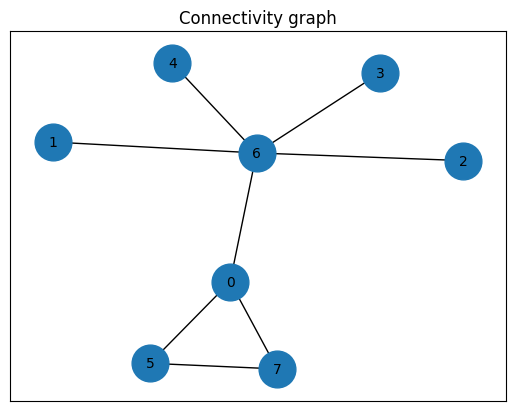

In [19]:

G = nx.Graph()
for triplet in test_graph:
    G.add_edge(triplet[0], triplet[2], weight=triplet[1])
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx(G, pos, with_labels=True, node_size=700, font_size=10)
plt.title(f'Connectivity graph')
plt.show()

## houses
Houses hold information about all the corner coordiniates, room_types, room indices, corner_indices, etc.


In [5]:
houses = data['houses']
num_coords = 2

cond = {
        'corner_coords': houses[idx][:, :num_coords],
        'room_types': houses[idx][:, num_coords: num_coords+25],
        'room_sizes': houses[idx][:, num_coords+25: num_coords+26],
        # 'room_types': self.houses[idx][:, self.num_coords:self.num_coords+25],
        'corner_indices': houses[idx][:, num_coords+25+1: num_coords+57+1],
        'room_indices': houses[idx][:, num_coords+57+1: num_coords+89+1],
        'src_key_padding_mask': 1-houses[idx][:, num_coords+89+1],
        'connections': houses[idx][:, num_coords+90+1: num_coords+92+1]
        }

corner_coords = cond['corner_coords'] # (100, 2), stores all the corner coordinates in x, y. Set to all zeros when passing to the model for inference.
room_types = cond['room_types'] # (100, 25) one-hot encoding of room types
room_sizes = cond['room_sizes'] # (100, 1) room sizes
corner_indices = cond['corner_indices'] # (100, 32) # one-hot encoding of corner indices
room_indices = cond['room_indices'] # (100, 32) # one-hot encoding of room indices
src_key_padding_mask = cond['src_key_padding_mask'] # (100,) # mask for the key padding
connections = cond['connections'] # (100, 2)


## boundary

In [7]:
boundary

array([[-0.6875   , -0.625    ],
       [-0.6875   ,  0.5546875],
       [ 0.0859375,  0.5546875],
       [ 0.09375  ,  0.6171875],
       [ 0.6796875,  0.6171875],
       [ 0.6796875, -0.09375  ],
       [ 0.59375  , -0.09375  ],
       [ 0.5859375, -0.59375  ],
       [-0.40625  , -0.59375  ],
       [-0.4140625, -0.625    ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0

In [26]:
boundary

array([[-0.6875   , -0.625    ],
       [-0.6875   ,  0.5546875],
       [ 0.0859375,  0.5546875],
       [ 0.09375  ,  0.6171875],
       [ 0.6796875,  0.6171875],
       [ 0.6796875, -0.09375  ],
       [ 0.59375  , -0.09375  ],
       [ 0.5859375, -0.59375  ],
       [-0.40625  , -0.59375  ],
       [-0.4140625, -0.625    ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0

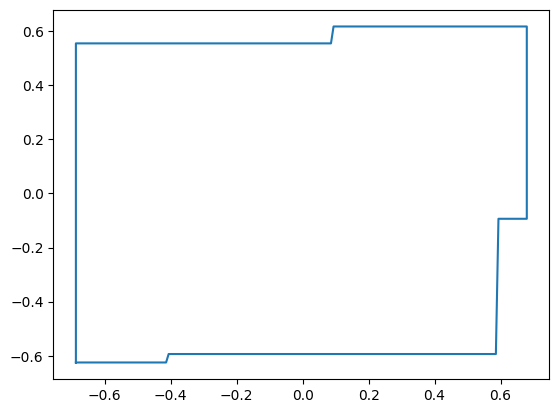

In [6]:
boundary = data['boundaries'][idx]
corners = boundary[boundary[:,0] != 0]
corners = np.vstack((corners, corners[0]))
poly = Polygon(corners)
x,y = poly.exterior.xy
plt.plot(x, y)
plt.show()

## Boundary mask (made from all the inputs)
The mask for boundary corners and room corners. 0 for boundary_mask[:boundary_num, :room_corner_num] 

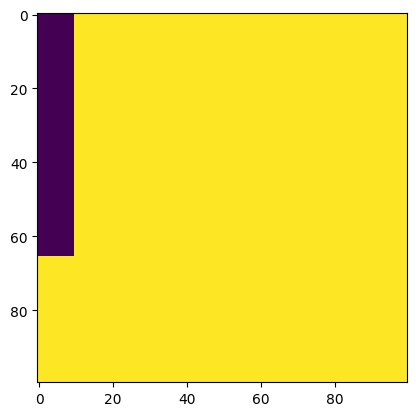

In [26]:
boundary_mask = data['boundary_masks'][idx] # 
plt.imshow(boundary_mask)


In [15]:
corner_coords[src_key_padding_mask==0].shape

(66, 2)

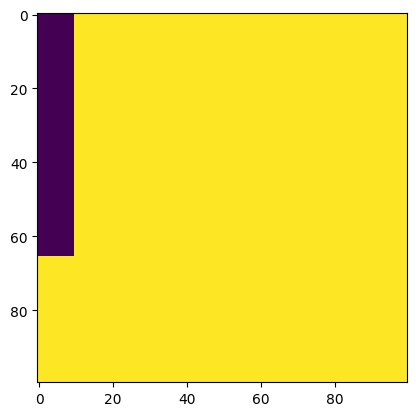

In [24]:
# example of making the boundary mask. 

test_boundary = boundary[(boundary[:, 0] != 0)&(boundary[:, 1] != 0)] # don't need to do that for the input
test_mask = np.ones((len(corner_coords), len(corner_coords))) 
test_mask[:len(corner_coords[src_key_padding_mask==0]), :len(test_boundary)] = 0
plt.imshow(test_mask)

## self mask
to show which corners belong to the same room / door, (0 for the purple part. )

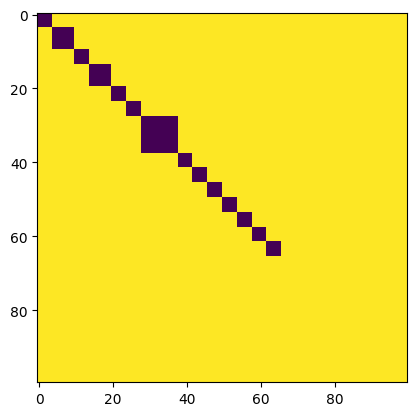

In [25]:
self_mask = data['self_masks'][idx]
plt.imshow(self_mask)

## Gen mask
Gen mask is to show the padding mask, 1 is the padding part, 0 is the real part

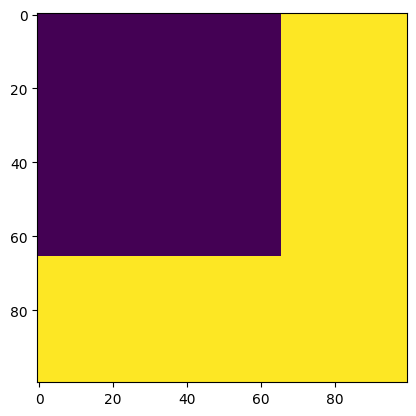

In [27]:
gen_mask = data['gen_masks'][idx] 
plt.imshow(gen_mask)

## boundary connection
The indices of boundary corners formatted for polygons (closed loop)

In [25]:
test_boundary

array([[-0.6875   , -0.625    ],
       [-0.6875   ,  0.5546875],
       [ 0.0859375,  0.5546875],
       [ 0.09375  ,  0.6171875],
       [ 0.6796875,  0.6171875],
       [ 0.6796875, -0.09375  ],
       [ 0.59375  , -0.09375  ],
       [ 0.5859375, -0.59375  ],
       [-0.40625  , -0.59375  ],
       [-0.4140625, -0.625    ]])

In [29]:
boundary_connection = data['boundary_connections'][idx] 


array([[0., 1.],
       [1., 2.],
       [2., 3.],
       [3., 4.],
       [4., 5.],
       [5., 6.],
       [6., 7.],
       [7., 8.],
       [8., 9.],
       [9., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

## min_dist (leave it for now)
min_dist for each room, they are repeated for each corner in the same room to match the corner_coords

In [31]:
min_dist = data['min_dists'][idx] 

## min_dist mask (leave it for now)
same as self mask but rule out the door part

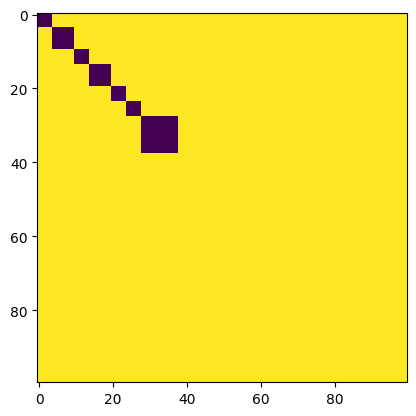

In [32]:
min_dist_mask = data['min_dist_masks'][idx]
plt.imshow(min_dist_mask)

## Some visualization

In [63]:
room_polys = []
room_colors = []
corner_coords[src_key_padding_mask==0]
room_indices_argmax = np.argmax(room_indices[src_key_padding_mask==0], axis=1)
room_types_argmax = np.argmax(room_types[src_key_padding_mask==0], axis=1)

for i in np.unique(room_indices_argmax):
    coords = (corner_coords[src_key_padding_mask==0][room_indices_argmax == i])
    coords = coords/2 + 0.5
    coords = coords * 256
    room_poly = Polygon(coords)
    room_color = ID_COLOR[room_types_argmax[room_indices_argmax == i][0]]
    room_colors.append(room_color)
    room_polys.append(room_poly)

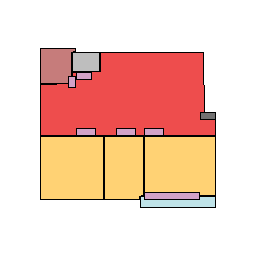

In [64]:
def plot_polygons(polygons, color_list, boundary=None):
    image = Image.new('RGB', (256, 256), "white")
    draw = ImageDraw.Draw(image)
    for i, c in zip(polygons, color_list):
        if isinstance(i, Polygon):
            x, y = i.exterior.xy
            draw.polygon(list(zip(x, y)), fill=c, outline ="black")
        else:
            draw.polygon([(x, y) for (x, y) in i], fill=c, outline ="black")
    if boundary is not None:
        draw.polygon([(x, y) for (x, y) in boundary],outline ="grey", width=2)
    # x, y = boundary.exterior.xy
    # draw.polygon(list(zip(x, y)), fill =0, outline ="white", alpha=0.5)
    image.show()

plot_polygons(room_polys, room_colors)

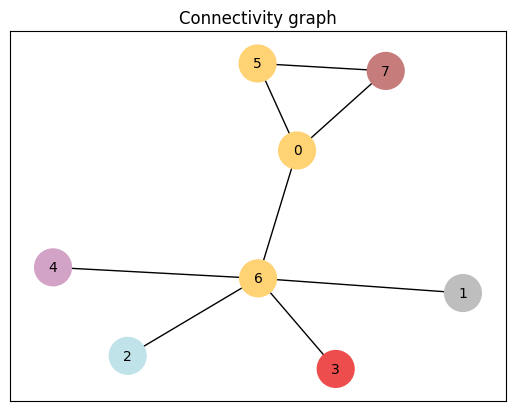

In [68]:

G = nx.Graph()
for triplet in test_graph:
    G.add_edge(triplet[0], triplet[2], weight=triplet[1])

# Draw the graph with the new interpretation
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'weight')
# node colors
nx.draw_networkx(G, pos, with_labels=True, node_size=700, node_color=room_colors[:room_num], font_size=10)
plt.title(f'Connectivity graph')
plt.show()